/tmp/ipykernel_19056/348334951.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


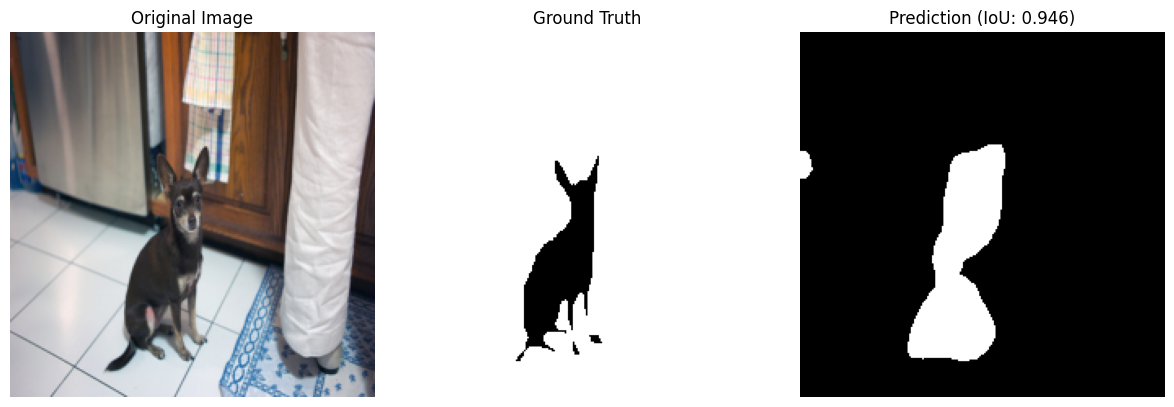

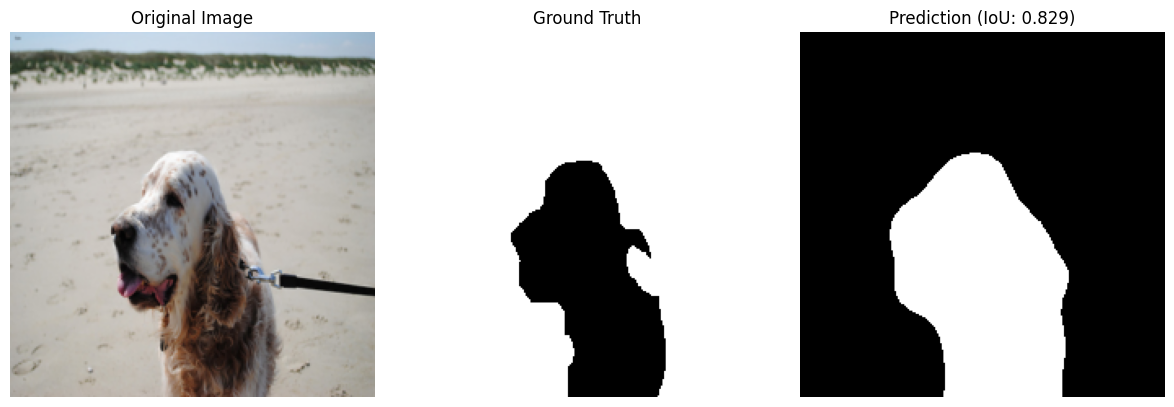

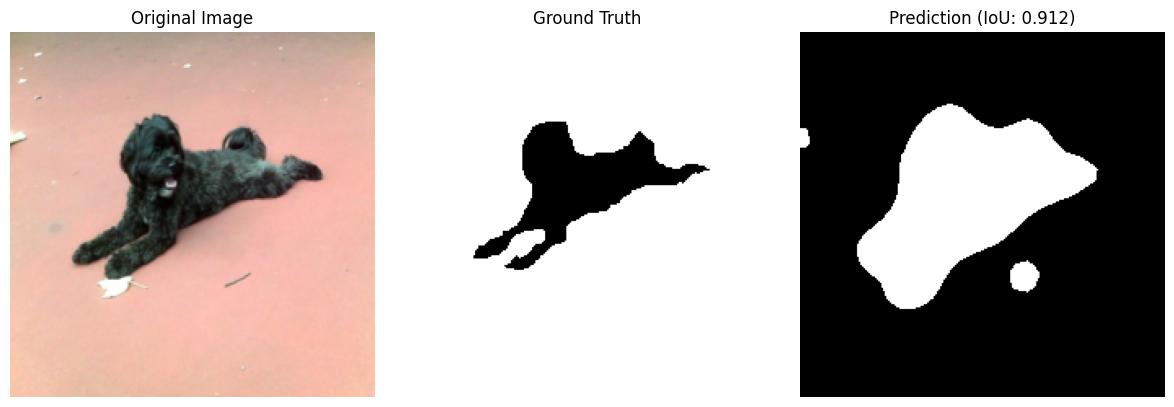

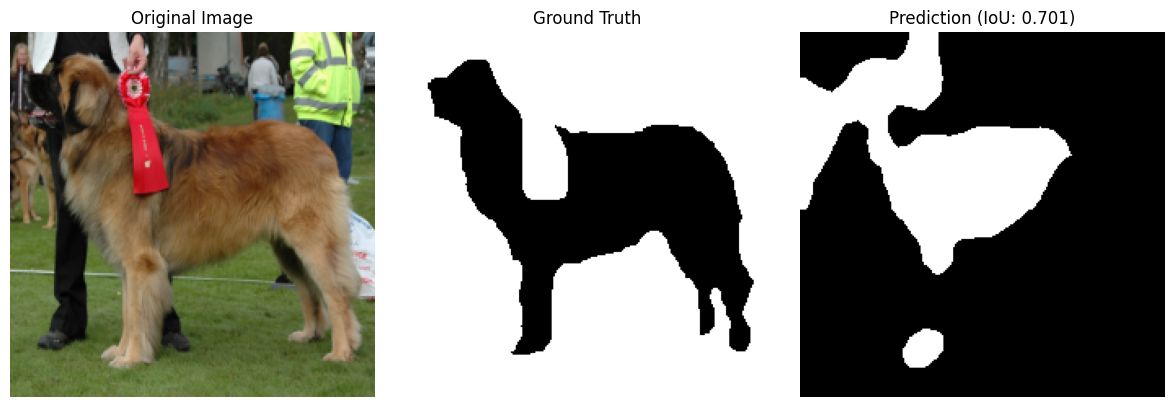

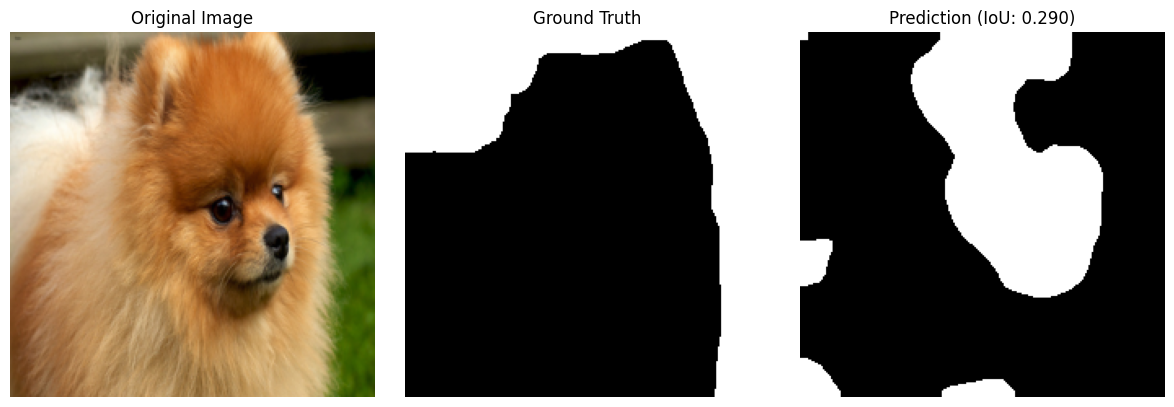


 Mean IoU on test set: 0.7016


In [43]:
import torch
from torchvision.models.segmentation import deeplabv3_resnet50, lraspp_mobilenet_v3_large
from torchvision import transforms
from torch.utils.data import DataLoader
from utils.utils import PetSegmentationDataset, compute_iou
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import numpy as np
import random
# --- Paths ---
model_path = Path("Models/segmentation_best_ws.pth")
test_image_dir = Path("Data/Split/test/images")
gt_mask_dir = Path("Data/annotations/trimaps")

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Transforms ---
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.NEAREST),
    transforms.ToTensor()
])

# --- Dataset (pass dummy path for mask_dir, won't be used) ---
test_dataset = PetSegmentationDataset(test_image_dir, mask_dir=gt_mask_dir, gt_mask_dir=gt_mask_dir,
                                    transform=img_transform, target_transform=mask_transform)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# --- Load model ---
model = deeplabv3_resnet50(pretrained=False, num_classes=1)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval().to(device)

# --- Evaluation ---
N = 5  # <-- change as needed
random_indices = set(random.sample(range(len(test_dataset)), N))

# Loop and collect IoU + visualize only if idx is in random_indices
total_iou = 0.0
for idx, (img, _, gt_mask) in enumerate(test_loader):
    img = img.to(device)
    gt_mask = gt_mask.to(device)

    with torch.no_grad():
        output = model(img)['out']
        pred_mask = torch.sigmoid(output)

    iou = compute_iou(pred_mask, gt_mask)
    total_iou += iou

    if idx in random_indices:
        img_np = img.squeeze().permute(1, 2, 0).cpu().numpy()
        img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img_np = np.clip(img_np, 0, 1)

        gt_mask_np = gt_mask.squeeze().cpu().numpy()
        pred_mask_np = (pred_mask.squeeze().cpu().numpy() > 0.5).astype(np.float32)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img_np)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask_np, cmap='gray')
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask_np, cmap='gray')
        plt.title(f"Prediction (IoU: {iou:.3f})")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

# --- Mean IoU ---
mean_iou = total_iou / len(test_loader)
print(f"\n Mean IoU on test set: {mean_iou:.4f}")


In [44]:
import torch
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision import transforms
from torch.utils.data import DataLoader
from utils.utils import PetSegmentationDataset, compute_iou
from PIL import Image
from pathlib import Path

# --- Paths ---
model_path = Path("Models/segmentation_best_ws.pth")
test_image_dir = Path("Data/Split/test/images")
gt_mask_dir = Path("Data/annotations/trimaps")

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Transforms ---
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.NEAREST),
    transforms.ToTensor()
])

# --- Dataset ---
test_dataset = PetSegmentationDataset(test_image_dir, mask_dir=gt_mask_dir, gt_mask_dir=gt_mask_dir,
                                    transform=img_transform, target_transform=mask_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# --- Load model ---
model = deeplabv3_resnet50(pretrained=False, num_classes=1)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval().to(device)

# --- Evaluation ---
total_iou = 0.0

for img, _, gt_mask in test_loader:
    img = img.to(device)
    gt_mask = gt_mask.to(device)

    with torch.no_grad():
        output = model(img)['out']
        pred_mask = torch.sigmoid(output)

    iou = compute_iou(pred_mask, gt_mask)
    total_iou += iou

# --- Mean IoU ---
mean_iou = total_iou / len(test_loader)
print(f" Mean IoU on test set: {mean_iou:.4f}")

/tmp/ipykernel_19056/759519330.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


 Mean IoU on test set: 0.7016


/tmp/ipykernel_19056/2211762581.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


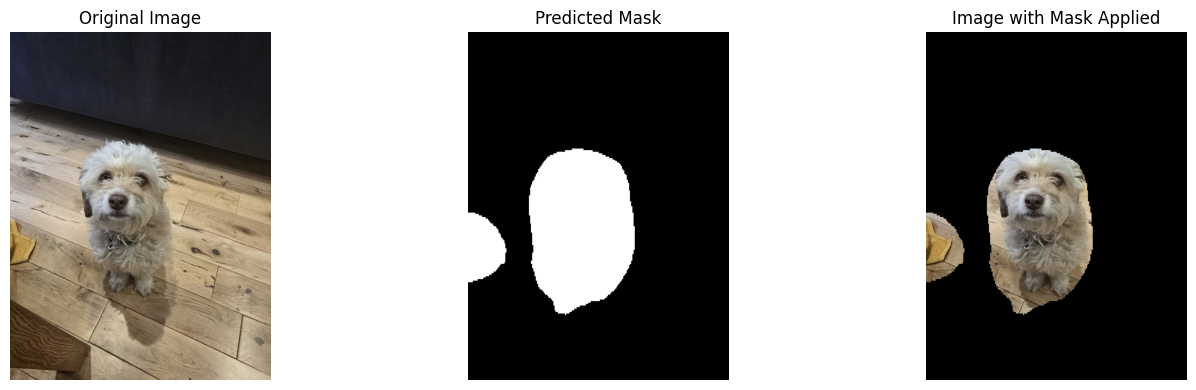

In [42]:
import torch
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import numpy as np
import cv2



# --- Paths ---
image_path = Path("roma.jpg")  # Your test image
model_path = Path("Models/segmentation_best_ws.pth")  # Path to your trained model

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Transforms ---
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# --- Load model ---
model = deeplabv3_resnet50(pretrained=False, num_classes=1)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval().to(device)

# --- Load and preprocess image ---
img = Image.open(image_path).convert("RGB")
img_tensor = img_transform(img).unsqueeze(0).to(device)

# --- Run model ---
with torch.no_grad():
    output = model(img_tensor)['out']
    pred_mask = torch.sigmoid(output).squeeze().cpu().numpy()
    pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)

# --- Display result ---
# Resize mask to original image size (just for alignment)
pred_mask_resized = cv2.resize(pred_mask_bin.astype(np.uint8), img.size, interpolation=cv2.INTER_NEAREST)

# Convert image to NumPy (if not already)
img_np_full = np.array(img)

# Apply mask: keep only pet pixels
masked_img = img_np_full.copy()
masked_img[pred_mask_resized == 0] = 0  # Black out everything else

# --- Updated Plot ---
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_np_full)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(pred_mask_resized, cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(masked_img)
plt.title("Image with Mask Applied")
plt.axis("off")

plt.tight_layout()
plt.show()


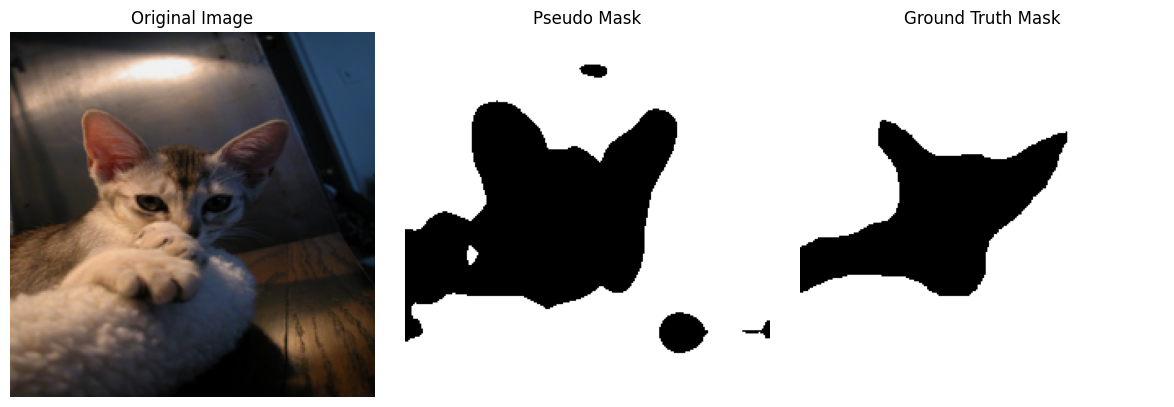

In [4]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from pathlib import Path
from PIL import Image
from torchvision.datasets import VisionDataset
import os

# --- Custom Dataset ---
class PetSegmentationDataset(VisionDataset):
    def __init__(self, image_dir, mask_dir, gt_mask_dir, transform=None, target_transform=None):
        super().__init__(image_dir)
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.gt_mask_dir = Path(gt_mask_dir)
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg")])
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        gt_mask_name = img_name
        img = Image.open(self.image_dir / img_name).convert("RGB")
        mask = Image.open(self.mask_dir / img_name.replace(".jpg", ".png"))
        gt_mask = Image.open(self.gt_mask_dir / gt_mask_name.replace(".jpg", ".png"))

        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            mask = self.target_transform(mask)
            gt_mask = self.target_transform(gt_mask)

        # mask = (mask * 255).byte()
        # Pseudo mask fix
        mask = (mask >= 0.5).float()

        # Ground truth (pet + boundary)
        gt_mask = gt_mask.squeeze(0) * 255
        gt_mask = ((gt_mask == 2) | (gt_mask == 3)).float().unsqueeze(0)

        return img, mask, gt_mask


# --- Paths ---
image_dir = "Data/Split/train/images"
mask_dir = "RefinedMasks"
gt_mask_dir = "Data/annotations/trimaps"

# --- Transforms ---
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
mask_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.NEAREST),
    transforms.ToTensor()
])

# --- Load Dataset ---
dataset = PetSegmentationDataset(image_dir, mask_dir, gt_mask_dir,
                                  transform=img_transform,
                                  target_transform=mask_transform)

# --- Visualize First Sample ---
def unnormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return (tensor * std + mean).clamp(0, 1)

img, pseudo_mask, gt_mask = dataset[0]
img = unnormalize(img).permute(1, 2, 0).numpy()
pseudo_mask = pseudo_mask.squeeze().numpy()
gt_mask = gt_mask.squeeze().numpy()

# --- Plot ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(pseudo_mask, cmap='gray')
plt.title("Pseudo Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(gt_mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis("off")

plt.tight_layout()
plt.show()
